## SynDiffix Clustering Strategies

When SynDiffix is given a dataset with a large number of columns, it partitions the dataset into a set of datasets with fewer columns. Doing so both improves synthetic data quality and speeds execution. This is called clustering.

There are three different approaches to clustering:
* **Balanced:** Place correlated columns in the same cluster. This is the default.
* **Targeted:** Chooses columns that are strongly correlated with a specified target column. This should be used when the synthesized data will be trained on an ML model for the target column.
* **None:** No clusters are built; each column is independently synthesized. This maximizes the data accuracy of each individual column. It runs faster than the other approaches.

### Setup

Let's install `syndiffix`, along with some other libraries that we will need for our experiments:

In [2]:
%pip install -q syndiffix numpy pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


We want to generate some raw data and visualize it. We'll import numpy, pandas, and seaborn:

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility.
np.random.seed(123)

### Generating the original data

Let's define a function to generate a set of mutually correlated columns. We call this set of columns a *cluster*.
This is not to be confused with *data clusters* that we use in statistics and data science.
A *cluster of columns* is a group of columns with some mutual dependence between those columns.

In [4]:
def generate_correlated_data(name_prefix, num_rows, correlation):
    mean = [0, 0, 0]
    cov = [
        [1, correlation, correlation],
        [correlation, 1, correlation],
        [correlation, correlation, 1],
    ]
    data = np.random.multivariate_normal(mean, cov, num_rows)
    return pd.DataFrame(data, columns=[name_prefix + '0', name_prefix + '1', name_prefix + '2'])

We want three clusters of three columns each. We put them all in the same dataframe:

In [5]:
num_rows = 10_000
cluster1 = generate_correlated_data('c0', num_rows, 0.8)
cluster2 = generate_correlated_data('c1', num_rows, 0.9)
cluster3 = generate_correlated_data('c2', num_rows, 0.7)
orig_data = pd.concat([cluster1, cluster2, cluster3], axis=1)

orig_data

,c00,c01,c02,c10,c11,c12,c20,c21,c22
0,1.113996,0.643614,1.274391,1.490387,0.957531,0.607358,-0.949416,0.218050,-0.327839
1,2.005303,1.283744,0.917805,-1.799318,-1.928713,-1.334698,-1.303708,-1.250899,-0.453162
2,2.721370,2.163622,1.892354,0.918482,0.615235,0.404111,0.102741,0.533692,0.084651
3,0.772309,1.038865,0.609500,-0.386743,-0.823801,-0.757547,-1.249712,-0.247270,-0.156711
4,-1.550527,-1.105310,-1.509387,-0.026917,-0.750600,-0.054838,-0.053336,-0.452075,-0.397561
...,...,...,...,...,...,...,...,...,...
9995,0.315563,-0.177450,0.002922,-0.423997,-1.222969,-1.104780,0.405741,0.552949,2.045296
9996,0.544658,0.347411,0.181096,0.748042,0.676200,0.458530,-1.050100,-0.390044,-0.913815
9997,-1.066854,-0.629549,-0.180794,0.889125,1.279303,1.154667,-0.672388,-0.504299,0.489039
9998,0.304900,0.520767,-0.382557,0.427856,0.216988,0.444719,-0.480614,-0.125737,-0.301431


Let's visualize the correlation matrix with a heatmap.

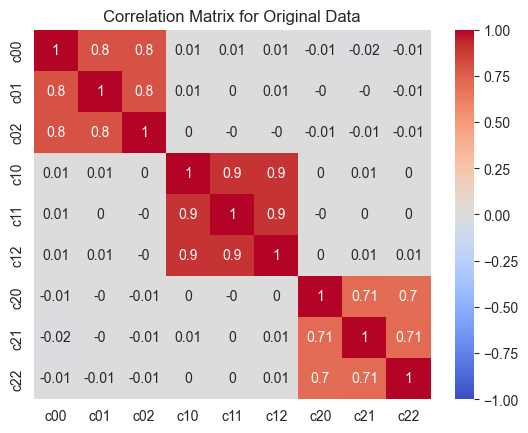

In [6]:
def show_heatmap(df, title):
    correlation_matrix = df.corr().round(2)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.show()

show_heatmap(orig_data, 'Correlation Matrix for Original Data')

### SynDiffix with default clustering

Next, let us synthesize the data using SynDiffix with its default parameters.

In [5]:
from syndiffix import Synthesizer

syn_data_balanced = Synthesizer(orig_data).sample()

The result is a dataframe, and we can measure its correlation matrix.

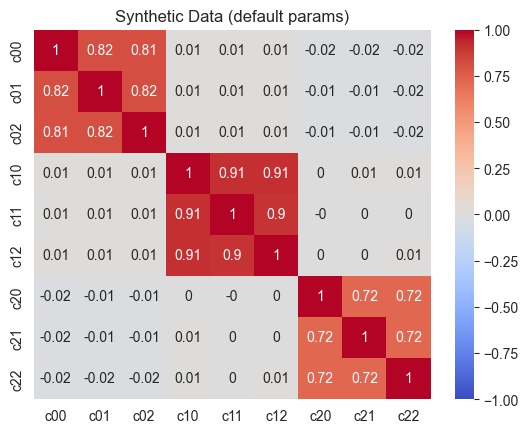

In [8]:
show_heatmap(syn_data_balanced, 'Synthetic Data (default params)')

We see that correlations mirror the original data quite well. This happens because SynDiffix detects dependence between columns and synthesizes highly dependent columns together.

### SynDiffix without clustering

Let's synthesize the data again, this time disabling column clustering.

In [9]:
from syndiffix.clustering.strategy import NoClustering

syn_data_no_clustering = Synthesizer(orig_data, clustering=NoClustering()).sample()

Let's show the correlation matrix for this output.

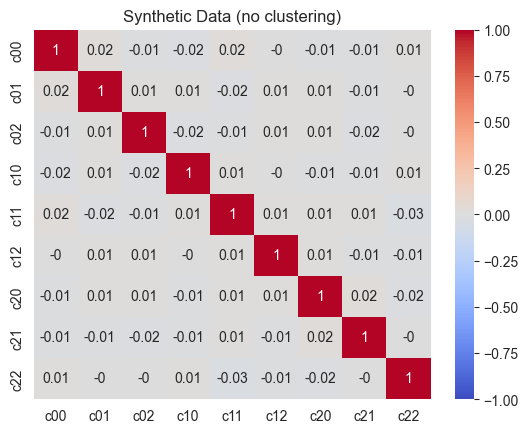

In [10]:
show_heatmap(syn_data_no_clustering, 'Synthetic Data (no clustering)')

We see that there is no correlation at all between columns. This happens because each column is synthesized independently without considering any relationships to other columns.

### SynDiffix with ML optimized clustering

There is also an `MlClustering` strategy, which allows us to pick a particular column to use as the prediction target for machine learning.
It uses feature selection to determine the most relevant features for the target.

Let's build a synthetic dataset for which we want to train a model to predict column `c00` (the first one).

In [9]:
from syndiffix.clustering.strategy import MlClustering
from syndiffix import Synthesizer
mlc = MlClustering(target_column='c00') # drop_non_features=True
syner_ml = Synthesizer(orig_data, clustering=mlc)
syn_data_ml = syner_ml.sample()

KeyboardInterrupt: 

There exists a shorthand syntax for the above, which can be written as:

```py
syn_data_ml = Synthesizer(orig_data, target_column='c00').sample()
```

Let's show the correlation matrix of this synthetic dataset.

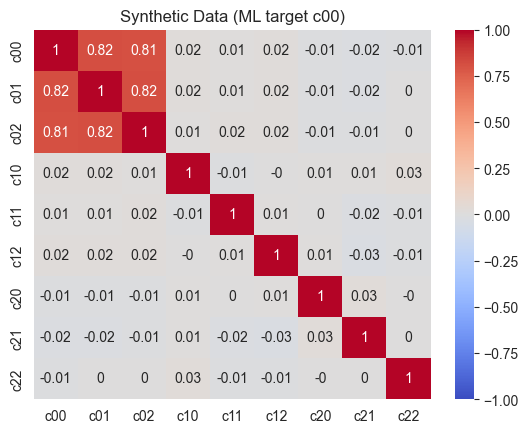

In [12]:
show_heatmap(syn_data_ml, 'Synthetic Data (ML target c00)')

We notice that we have preserved the correlations of column `c00`, but not the others.
This happens because if we want to predict column `c00`, the only features that are useful to predict `c00` are `c01` and `c02`.

We can optionally drop irrelevant columns by setting `drop_non_features`:

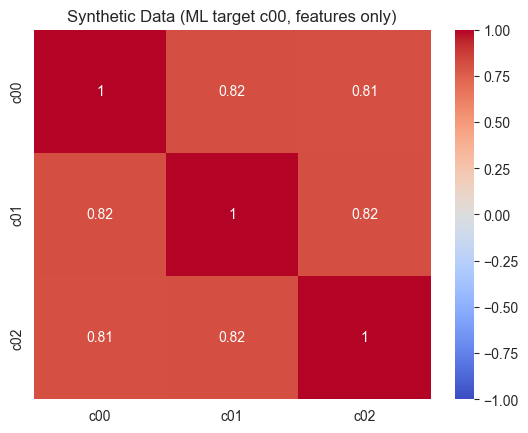

In [13]:
syn_data_ml_features_only = Synthesizer(
    orig_data,
    clustering=MlClustering(target_column="c00", drop_non_features=True)
).sample()

show_heatmap(syn_data_ml_features_only, "Synthetic Data (ML target c00, features only)")

The resulting dataframe contains only the target column and feature columns. We might want to do this in cases where there are a lot of irrelevant columns that degrade the quality of an ML model.

In [14]:
syn_data_ml_features_only

,c00,c01,c02
0,1.061655,0.828695,1.271090
1,1.020195,0.769592,1.371314
2,1.093744,0.898704,1.311409
3,1.134990,0.753356,1.290212
4,1.160617,0.843740,1.394131
...,...,...,...
9996,0.185590,0.044770,-1.167603
9997,0.185677,0.043991,-1.167664
9998,0.155089,0.087340,-1.129988
9999,0.154733,0.087114,-1.129121
